In [102]:
# Reading stock data using pandas_datareader library

import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import pandas_datareader as web
import datetime

# Line below is the fix for is_list_like lib
pd.core.common.is_list_like = pd.api.types.is_list_like

start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2019, 12 , 31)

# Importing stock data of 'Amazon' into python object
amazon = web.DataReader('AMZN', 'yahoo', start, end)
writer = ExcelWriter('Amazon-Stocks.xlsx')
amazon.to_excel(writer,'Sheet1',index=False)
writer.save()
amazon.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,314.750000,306.959991,312.579987,308.519989,2783200,308.519989
2015-01-05,308.380005,300.850006,307.010010,302.190002,2774200,302.190002
2015-01-06,303.000000,292.380005,302.239990,295.290009,3519000,295.290009
2015-01-07,301.279999,295.329987,297.500000,298.420013,2640300,298.420013
2015-01-08,303.140015,296.109985,300.320007,300.459991,3088400,300.459991


Let's analyse stock prices of Amazon using matplot library!

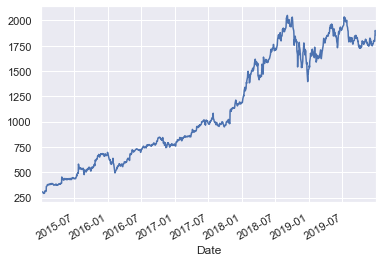

In [103]:
# Plotting 'High' price of Amazon stock using matplotlib library

import matplotlib.pyplot as plt
%matplotlib inline
high = amazon['High']
high.plot()

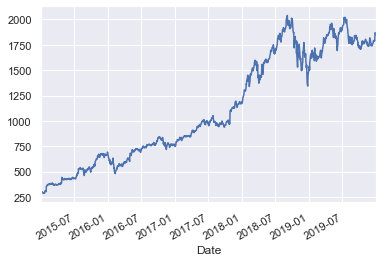

In [104]:
# Plotting 'Close' price of Amazon stock using matplotlib library

close = amazon['Close']
close.plot()

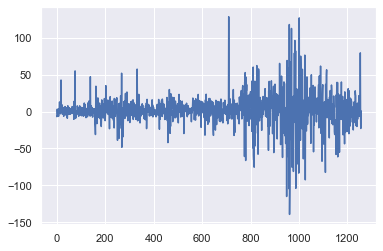

In [105]:
# Plotting difference of 'Close' price using matplotlib library

import numpy as np
delta = np.diff(close)
plt.plot(delta)

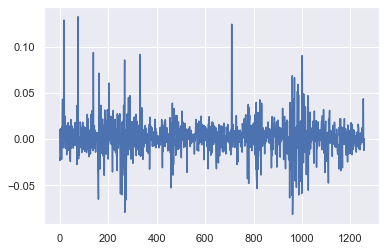

In [106]:
# Plotting difference of logarithm of 'Close' price to squash big growths, using matplotlib library

import numpy as np
returns = np.diff(np.log(close))
plt.plot(returns)

Do you want to see the correlation between high and close prices of Amazon stock? We have just the function in pandas to correlate values

In [107]:
# Checking correlation between 'High' and 'Close' price of stock

high.corr(close)

0.9997045515506809

Looks like there's high correlation between 'High' and 'Close' price of stock. 

Let's do exponential smoothing to determine how fast the weight decreases for previous observations and use 0.05 and 0.3 as values for the smoothing factor.

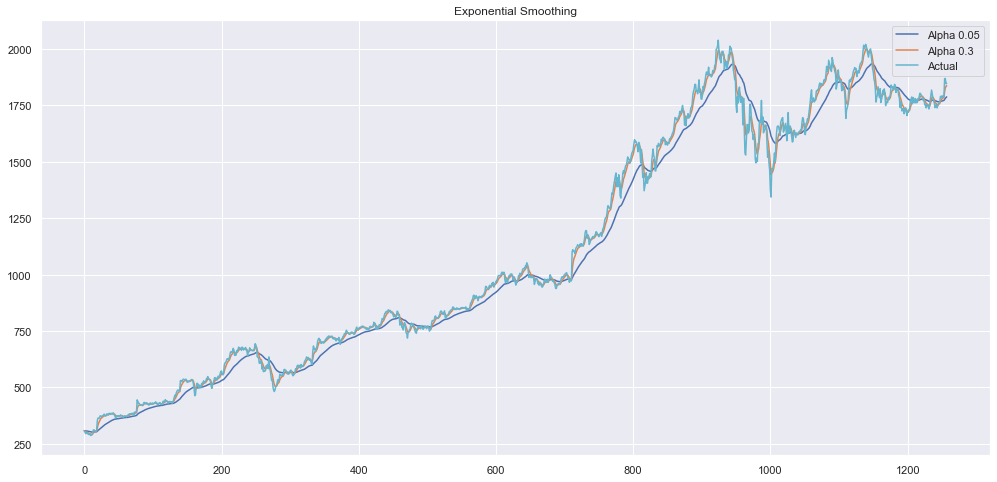

In [108]:
# Exponential soothing on 'Close' price of Amazon stock

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(amazon.Close, [0.05, 0.3])

Let's apply double exponential smoothing to smoothen the trends in the time series

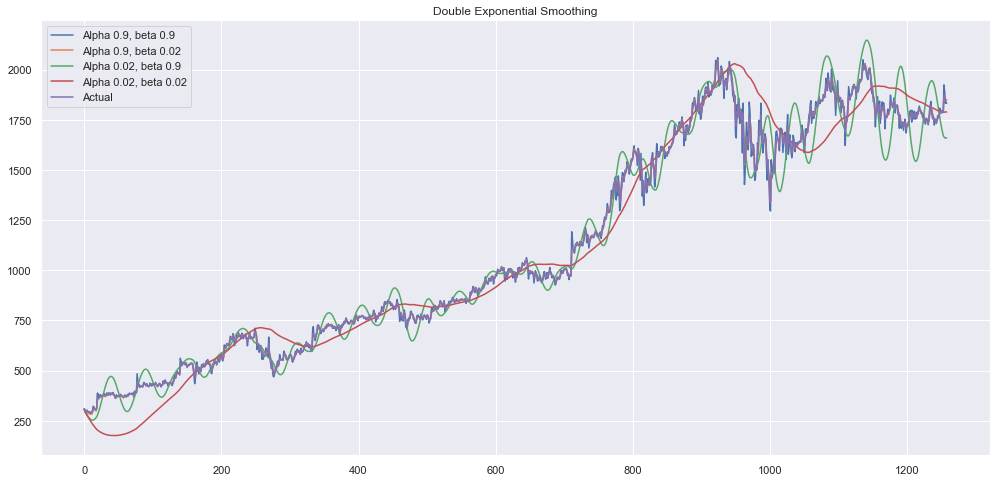

In [109]:
# Double exponential soothing on 'Close' price of Amazon stock

def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(amazon.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Observing the plotting for single and double exponential smoothening, we can conclude that Amazon's closing stock is non-stationary. Implying, there are trends and patterns that can be extracted. 
Now, we'll check the stationarity using Dicky-Fuller Test.

DICKY-FULLER TEST :

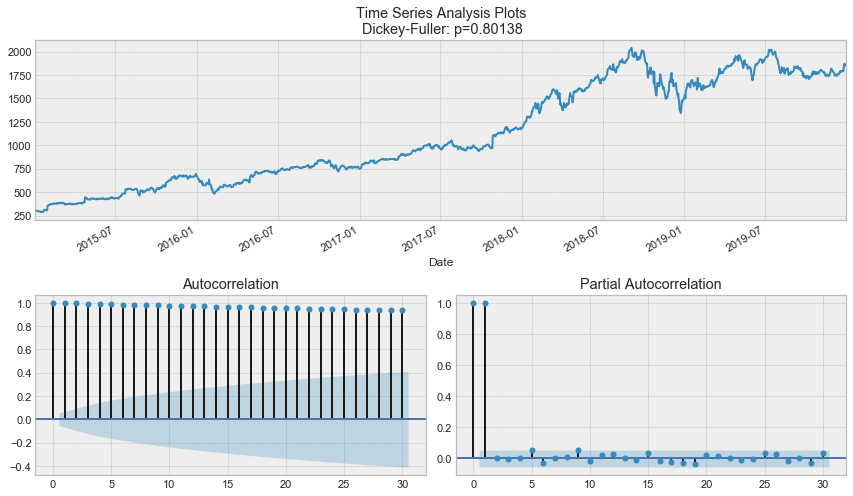

In [110]:
# Stationarity of closing stock

import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(amazon.Close, lags=30)

By the Dickey-Fuller test, the time series is non-stationary.

Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference: We simply subtract the time series from itself with a lag of one day, and we get:

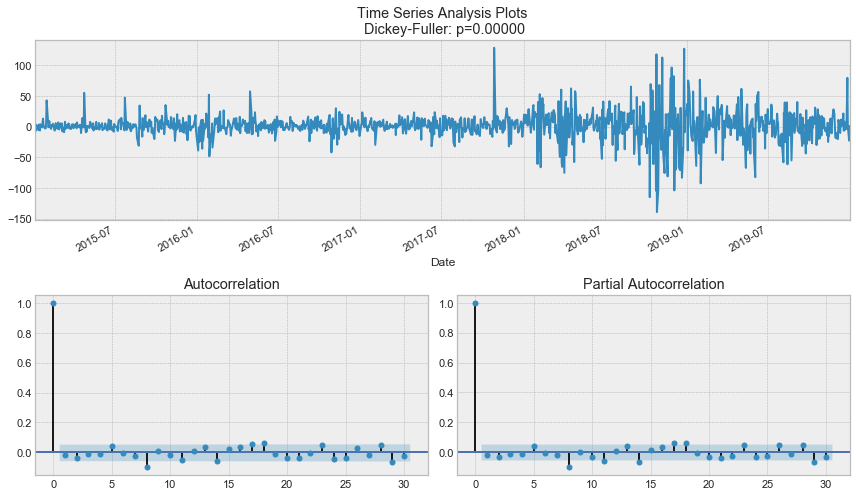

In [111]:
# Considering the first difference to remove high autocorrelation and to make the process stationary

data_diff = amazon.Close - amazon.Close.shift(1)
tsplot(data_diff[1:], lags=30)

The series is now stationary for modelling!

Let's go ahead with training a model to learn from the available stock data. First, we will start with some data pre-processing

In [112]:
# View stock data of Amazon

amazon.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,314.750000,306.959991,312.579987,308.519989,2783200,308.519989
2015-01-05,308.380005,300.850006,307.010010,302.190002,2774200,302.190002
2015-01-06,303.000000,292.380005,302.239990,295.290009,3519000,295.290009
2015-01-07,301.279999,295.329987,297.500000,298.420013,2640300,298.420013
2015-01-08,303.140015,296.109985,300.320007,300.459991,3088400,300.459991


In [113]:
# Importing required libraries for prediction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [114]:
# Retaining only columns useful for prediction and dropping the others

amazon.drop(['Adj Close','Volume'], axis=1, inplace=True)
amazon.head()

,High,Low,Open,Close
Date,,,,
2015-01-02,314.750000,306.959991,312.579987,308.519989
2015-01-05,308.380005,300.850006,307.010010,302.190002
2015-01-06,303.000000,292.380005,302.239990,295.290009
2015-01-07,301.279999,295.329987,297.500000,298.420013
2015-01-08,303.140015,296.109985,300.320007,300.459991


We will train a Random Forest with a sample of our data and test it with another sample to see how it performs. To do that, let's import the Scikit-learn modules.

In [115]:
# Importing scikit learn library for training the model

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

We are going to predict the Close price of Amazon stocks. To do that, we will shift the data in the 'Close' column up by a row because the data from previous day will be used to predict next day's close price

In [116]:
# Shift 'Close' price of stock to predict tomorrow's value based on today's

pd.concat([amazon.Close, amazon.Close.shift(-1)], axis=1)

,Close,Close
Date,,
2015-01-02,308.519989,302.190002
2015-01-05,302.190002,295.290009
2015-01-06,295.290009,298.420013
2015-01-07,298.420013,300.459991
2015-01-08,300.459991,296.929993
...,...,...
2019-12-24,1789.209961,1868.770020
2019-12-26,1868.770020,1869.800049
2019-12-27,1869.800049,1846.890015


Let's create our training and test variables. X is representing the multi-dimensional independent variables while y represents the dependent variable, i.e., the variable to be predicted.

In [117]:
# Splitting stock data into dependent and indepedent variables

X = amazon[['High','Low','Open']].iloc[:-720]
y = amazon.Close.shift(-720).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

We now create a ML model, using RandomForestRegressor from the sk-learn package. 

We then fit the model to the training data, where we fit a curve to the datapoints. This is basically function approximation, a step to find the function that fits through our data.

In [118]:
# Fit data points to the model

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Now, let's see how accurately our model performed in predicting future stock prices of Amazon!

In [119]:
#Calculating prediction accuracy of model

rf_model.score(X_test, y_test)

0.7242400518879601

So we are predicting with an accuracy of more than 70% from data 5 years into the past

Let's plot predictions over actual values to get a better view of the data

In [120]:
y_pred = rf_model.predict(X_test)

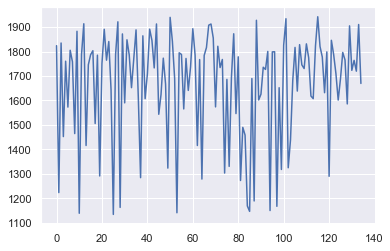

In [121]:
import matplotlib.pyplot as plt
plt.plot(y_pred)

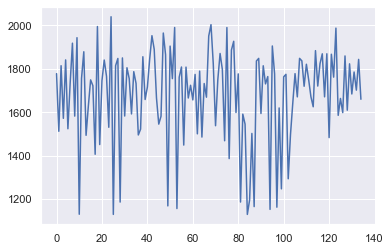

In [122]:
import matplotlib.pyplot as plt
plt.plot(y_test.as_matrix())

Now let's plot predictions on top of test labels to see if we have a match. We'll plot one under the other and then reverse them to see if the mismatch is big or not

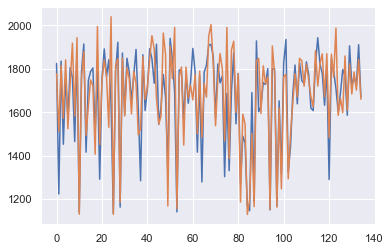

In [123]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test.as_matrix())

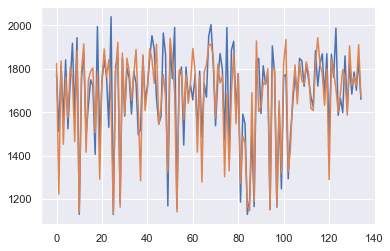

In [124]:
import matplotlib.pyplot as plt
plt.plot(y_test.as_matrix())
plt.plot(y_pred)